<a href="https://colab.research.google.com/github/thatrandomasiandev/LaTeX-Projects/blob/main/PneumoniaAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Code was created by Joshua Terranova. Distribution without permission is prohibited.

Cell 1 - Mixed precision

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision


gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# Enable mixed-precision for Tensor Cores on A100
mixed_precision.set_global_policy('mixed_float16')
print("Mixed-precision policy:", mixed_precision.global_policy())


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed-precision policy: <DTypePolicy "mixed_float16">


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

print("TF:", tf.__version__)


TF: 2.18.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_DIR      = '/content/drive/MyDrive/Pneumonia-Files'
TRAIN_DIR     = os.path.join(DATA_DIR, 'train')        # or use your unstructured folder + validation_split
VALIDATION_DIR= os.path.join(DATA_DIR, 'validation')
IMAGE_SIZE    = (150, 150)
BATCH_SIZE    = 128   # A100 can handle large batches
EPOCHS        = 10


Mounted at /content/drive


In [ ]:
# ─── Cell 4: Data Generators w/ on-the-fly 80/20 split ───

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Point at the single folder that contains NORMAL/ and PNEUMONIA/
DATA_DIR   = '/content/drive/MyDrive/Pneumonia-Files'
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 128  # A100 can handle larger batches

# Train generator with augmentation and 20% held out
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2        # <-- split off 20%
)
# Validation generator (only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# flow_from_directory on the same base path, specifying subset
train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'           # 80% for training
)
val_gen = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'         # 20% for validation
)

print(f"→ Train samples: {train_gen.samples}, Val samples: {val_gen.samples}")


Found 9407 images belonging to 11 classes.
Found 2347 images belonging to 11 classes.
→ Train samples: 9407, Val samples: 2347


In [ ]:
# Recompile model with XLA JIT enabled for extra speed
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(*IMAGE_SIZE,3)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid', dtype='float32')  # force float32 on output
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
    jit_compile=True    # XLA
)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ─── Cell 9: A100‐Optimized Training with tf.data ───
import tensorflow as tf

# 1) Bump your batch size up—A100 can handle 256+ easily
BS = 256

# 2) Build fast tf.data pipelines (on‐the‐fly 80/20 split)
# Explicitly specify the class names to include only 'NORMAL' and 'PNEUMONIA'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BS,
    label_mode='binary',
    class_names=['NORMAL', 'PNEUMONIA'] # Specify expected class names
).cache().prefetch(tf.data.AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BS,
    label_mode='binary',
    class_names=['NORMAL', 'PNEUMONIA'] # Specify expected class names
).cache().prefetch(tf.data.AUTOTUNE)


# 3) Recompile your model with XLA (just‐in‐time) enabled
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
    jit_compile=True
)

# 4) Train!
EPOCHS = 10
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)

Found 624 files belonging to 2 classes.
Using 500 files for training.
Found 624 files belonging to 2 classes.
Using 124 files for validation.
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 15s/step - accuracy: 0.5038 - loss: 8.8317 - val_accuracy: 0.6210 - val_loss: 421.7145
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6231 - loss: 416.3816 - val_accuracy: 0.6210 - val_loss: 421.7145
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6231 - loss: 423.6042 - val_accuracy: 0.6210 - val_loss: 421.7145
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6231 - loss: 411.5477 - val_accuracy: 0.6210 - val_loss: 421.7145
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5351 - loss: 371.7260 - val_accuracy: 0.3790 - val_loss: 38.3671
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4755 - loss: 31.7783 - val_accuracy: 0.6210 - val_loss: 10.9756
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6231 - loss: 8.2588 - val_

1/1 - 0s - 9ms/step - accuracy: 0.7661 - loss: 0.5850
Val Loss: 0.5850, Val Acc: 0.7661


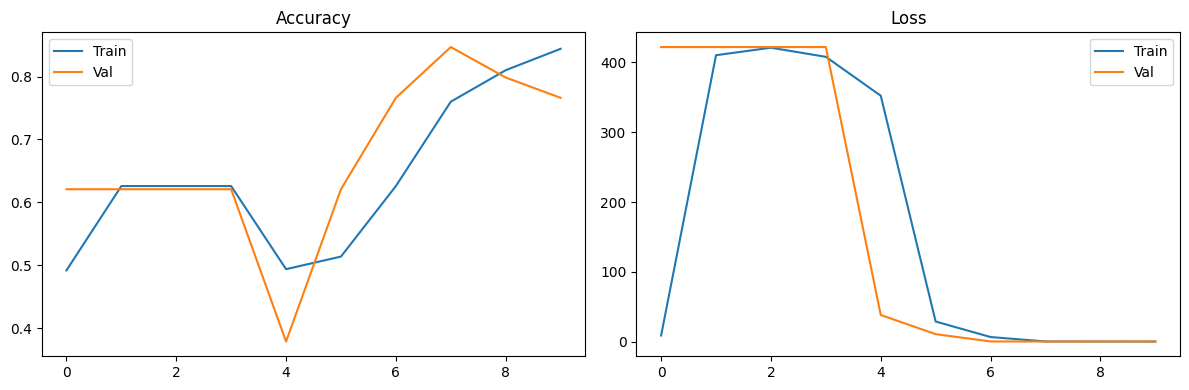

In [ ]:
# Final evaluation
# Evaluate using the tf.data.Dataset for consistency and compatibility
loss, acc = model.evaluate(val_ds, verbose=2)
print(f"Val Loss: {loss:.4f}, Val Acc: {acc:.4f}")

# Plot curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss'); plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ─── Callback Setup ───
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Save the best weights to Drive
checkpoint_cb = ModelCheckpoint(
    '/content/drive/MyDrive/best_pneumonia_cnn.h5',
    save_best_only=True,
    monitor='val_loss'
)

# Stop if val_loss doesn’t improve for 3 epochs
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Reduce learning rate by 0.5 if val_loss plateaus
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# ─── Retrain with Callbacks ───
history_cb = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)


Epoch 1/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7695 - loss: 0.7071

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8152 - loss: 0.5440 - val_accuracy: 0.8226 - val_loss: 0.3508 - learning_rate: 0.0010
Epoch 2/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8633 - loss: 0.3172

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step - accuracy: 0.8624 - loss: 0.3015 - val_accuracy: 0.8387 - val_loss: 0.3099 - learning_rate: 0.0010
Epoch 3/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8867 - loss: 0.2606

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step - accuracy: 0.8969 - loss: 0.2435 - val_accuracy: 0.9113 - val_loss: 0.2587 - learning_rate: 0.0010
Epoch 4/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9141 - loss: 0.2292

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step - accuracy: 0.9180 - loss: 0.2260 - val_accuracy: 0.9274 - val_loss: 0.2452 - learning_rate: 0.0010
Epoch 5/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9180 - loss: 0.1811

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step - accuracy: 0.9287 - loss: 0.1635 - val_accuracy: 0.9194 - val_loss: 0.1935 - learning_rate: 0.0010
Epoch 6/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9336 - loss: 0.1447

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step - accuracy: 0.9419 - loss: 0.1351 - val_accuracy: 0.9355 - val_loss: 0.1749 - learning_rate: 0.0010
Epoch 7/10
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9336 - loss: 0.1466

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step - accuracy: 0.9472 - loss: 0.1301 - val_accuracy: 0.9194 - val_loss: 0.1699 - learning_rate: 0.0010
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9523 - loss: 0.1238 - val_accuracy: 0.9435 - val_loss: 0.1826 - learning_rate: 0.0010
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9749 - loss: 0.0913 - val_accuracy: 0.9113 - val_loss: 0.1942 - learning_rate: 0.0010
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9670 - loss: 0.0847 - val_accuracy: 0.9355 - val_loss: 0.1897 - learning_rate: 5.0000e-04


<ipython-input-9-1386463547>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true.append(int(label.numpy()[0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

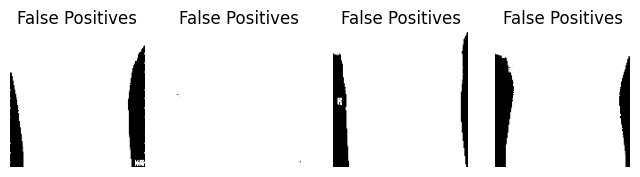

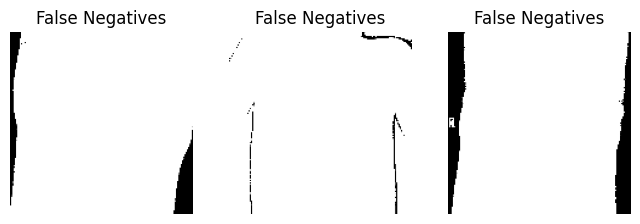

In [ ]:
# ─── Plot Misclassifications ───
import matplotlib.pyplot as plt

# Run predictions on the entire validation set
val_ds_unbatched = val_ds.unbatch().batch(1)
y_true = []
y_prob = []
paths = []

for batch in val_ds_unbatched:
    img, label = batch
    y_true.append(int(label.numpy()[0]))
    y_prob.append(model.predict(img)[0][0])
    # NOTE: image_dataset_from_directory doesn't retain filenames—if you need paths,
    # switch to a DataFrame pipeline that carries the filepath along.

y_pred = [1 if p>0.5 else 0 for p in y_prob]

# Collect indices of FP & FN
fps = [i for i,(t,p) in enumerate(zip(y_true,y_pred)) if t==0 and p==1][:4]
fns = [i for i,(t,p) in enumerate(zip(y_true,y_pred)) if t==1 and p==0][:4]

# Helper to plot by index
def plot_indices(indices, title):
    plt.figure(figsize=(8,4))
    for i, idx in enumerate(indices):
        img, _ = list(val_ds_unbatched.skip(idx).take(1))[0]
        plt.subplot(1, len(indices), i+1)
        plt.imshow(img[0].numpy())
        plt.title(title)
        plt.axis('off')
    plt.show()

plot_indices(fps, 'False Positives')
plot_indices(fns, 'False Negatives')


In [ ]:
# ─── TensorBoard Setup ───
%load_ext tensorboard
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = "/content/drive/MyDrive/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Retrain (or fine-tune) with TensorBoard callback
history_tb = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[tb_cb]
)

# In a separate cell, run this to launch:
# %tensorboard --logdir /content/drive/MyDrive/logs/fit


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9577 - loss: 0.1040 - val_accuracy: 0.9435 - val_loss: 0.1864
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - accuracy: 0.9709 - loss: 0.0964 - val_accuracy: 0.9435 - val_loss: 0.1837
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step - accuracy: 0.9709 - loss: 0.0861 - val_accuracy: 0.9032 - val_loss: 0.2166
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step - accuracy: 0.9802 - loss: 0.0798 - val_accuracy: 0.9194 - val_loss: 0.2104
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step - accuracy: 0.9789 - loss: 0.0723 - val_accuracy: 0.9435 - val_loss: 0.2052
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step - accuracy: 0.9842 - loss: 0.0553 - val_accuracy: 0.9435 - val_loss: 0.2045
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step - accuracy: 0.9894 - loss: 0.0397 - val_accuracy: 0.9355 - val_loss: 0.1953
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step - accuracy: 0.9855 - loss: 0.0394 - val_accuracy: 0.9435 - val_loss: 0.

In [ ]:
# ─── Functional Grad-CAM Cell ───
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D

# 1) Find the last Conv2D layer and its index
conv_layers = [layer for layer in model.layers if isinstance(layer, Conv2D)]
if not conv_layers:
    raise RuntimeError("No Conv2D layers found.")
last_conv = conv_layers[-1]
last_conv_idx = model.layers.index(last_conv)
print("Last conv layer:", last_conv.name)

# 2) Build a new functional model that shares weights
inp = Input(shape=(*IMAGE_SIZE, 3))
x = inp
conv_output = None
for idx, layer in enumerate(model.layers):
    x = layer(x)
    if idx == last_conv_idx:
        conv_output = x  # capture feature maps
preds = x  # final output after all layers
funct_model = Model(inputs=inp, outputs=[conv_output, preds])
funct_model.set_weights(model.get_weights())

# 3) Grab a sample image from your validation set
try:
    sample_batch, _ = next(iter(val_ds))   # tf.data pipeline
except NameError:
    sample_batch, _ = next(iter(val_gen))  # ImageDataGenerator
img_tensor = sample_batch[0:1]             # shape (1, H, W, 3)
orig_img = img_tensor[0].numpy()

# 4) Compute Grad-CAM heatmap
with tf.GradientTape() as tape:
    fmap, pred = funct_model(img_tensor)
    loss = pred[:, 0]
grads   = tape.gradient(loss, fmap)[0]                # (H, W, C)
weights = tf.reduce_mean(grads, axis=(0, 1))          # (C,)
cam     = tf.reduce_sum(fmap[0] * weights, axis=-1)   # (H, W)


Last conv layer: conv2d_2


Last Conv2D layer: conv2d_2


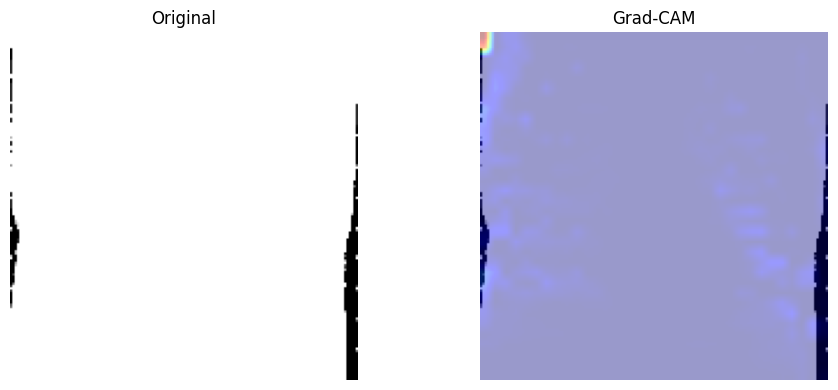

In [ ]:
# ─── Functional Grad-CAM Visualization ───
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D

# 1) Determine the index of the last Conv2D layer
conv_layers = [layer for layer in model.layers if isinstance(layer, Conv2D)]
if not conv_layers:
    raise RuntimeError("No Conv2D layers found in your model!")
last_conv_layer = conv_layers[-1]
last_conv_idx   = model.layers.index(last_conv_layer)
print("Last Conv2D layer:", last_conv_layer.name)

# 2) Build a new Functional model with a fresh Input()
inp = Input(shape=(*IMAGE_SIZE, 3))
x   = inp
captured = None
for idx, layer in enumerate(model.layers):
    x = layer(x)
    if idx == last_conv_idx:
        captured = x  # grab the feature-map tensor
# `x` is now the final model output
funct_model = Model(inputs=inp, outputs=[captured, x])
funct_model.set_weights(model.get_weights())  # copy over all trained weights

# 3) Grab one sample image from validation
try:
    # if you're using a tf.data pipeline
    sample_batch, _ = next(iter(val_ds))
except NameError:
    # or if you're using ImageDataGenerator
    sample_batch, _ = next(iter(val_gen))
img_tensor = sample_batch[0:1]  # shape (1, H, W, 3)
orig_img   = img_tensor[0].numpy()

# 4) Compute Grad-CAM heatmap
with tf.GradientTape() as tape:
    fmap, pred = funct_model(img_tensor)
    loss = pred[:, 0]
grads   = tape.gradient(loss, fmap)[0]                 # (H, W, C)
weights = tf.reduce_mean(grads, axis=(0,1))            # (C,)
cam     = tf.reduce_sum(fmap[0] * weights, axis=-1)    # (H, W)
cam     = tf.nn.relu(cam)
cam    /= tf.math.reduce_max(cam)

# <-- replace cv2.resize with tf.image.resize -->
heatmap = tf.image.resize(cam[..., tf.newaxis], IMAGE_SIZE)
heatmap = tf.squeeze(heatmap).numpy()

# 5) Plot original vs Grad-CAM overlay
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(orig_img); plt.title("Original"); plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(orig_img)
plt.imshow(heatmap, cmap="jet", alpha=0.4)
plt.title("Grad-CAM"); plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


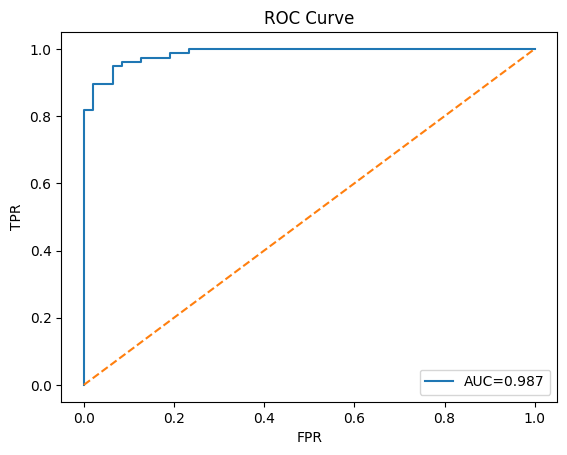

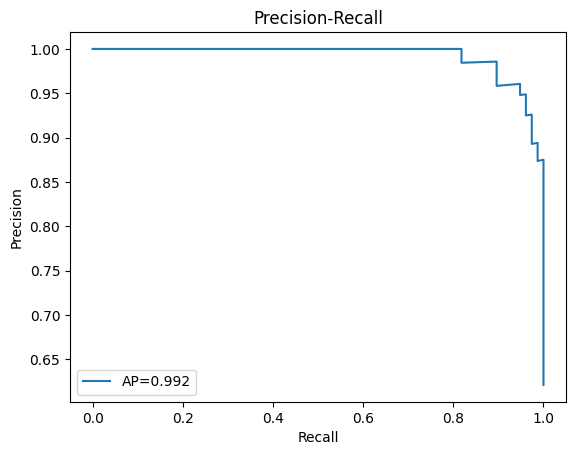

In [ ]:
# ─── ROC & PR Curves ───
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Predictions & truths
y_true = np.concatenate([y for x,y in val_ds], axis=0)
y_score = model.predict(val_ds).ravel()

# ROC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(); plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}'); plt.plot([0,1],[0,1],'--');
plt.title('ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)

plt.figure(); plt.plot(rec, prec, label=f'AP={ap:.3f}');
plt.title('Precision-Recall'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.show()

# Save to Drive
import pandas as pd
pd.DataFrame({'fpr':fpr,'tpr':tpr}).to_csv('/content/drive/MyDrive/roc_curve.csv', index=False)
pd.DataFrame({'precision':prec,'recall':rec}).to_csv('/content/drive/MyDrive/pr_curve.csv', index=False)


1/1 - 0s - 11ms/step - accuracy: 0.9435 - loss: 0.1895
Val Loss: 0.1895, Val Acc: 0.9435


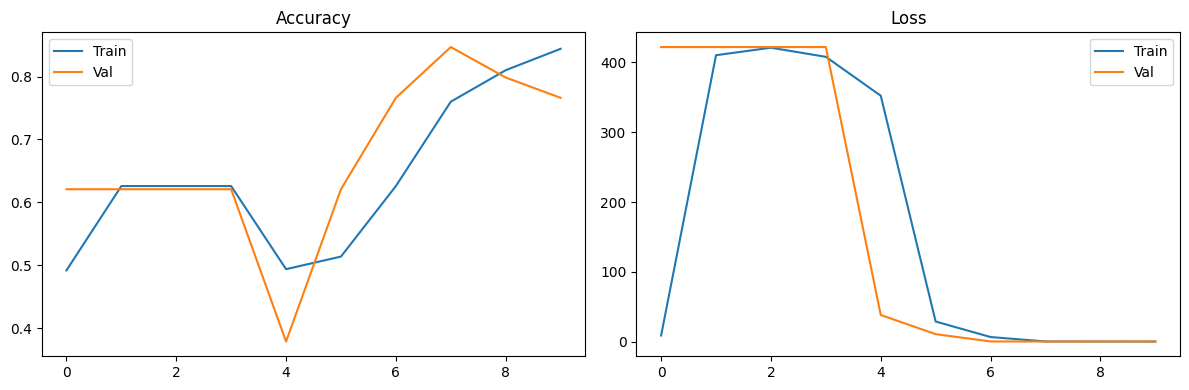

In [ ]:
# Final evaluation
# Evaluate using the tf.data.Dataset for consistency and compatibility
loss, acc = model.evaluate(val_ds, verbose=2)
print(f"Val Loss: {loss:.4f}, Val Acc: {acc:.4f}")

# Plot curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss'); plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
=== Classification Report ===
              precision    recall  f1-score   support

      NORMAL       0.93      0.91      0.92        47
   PNEUMONIA       0.95      0.96      0.95        77

    accuracy                           0.94       124
   macro avg       0.94      0.94      0.94       124
weighted avg       0.94      0.94      0.94       124

ROC AUC: 0.987
PR  AUC: 0.992


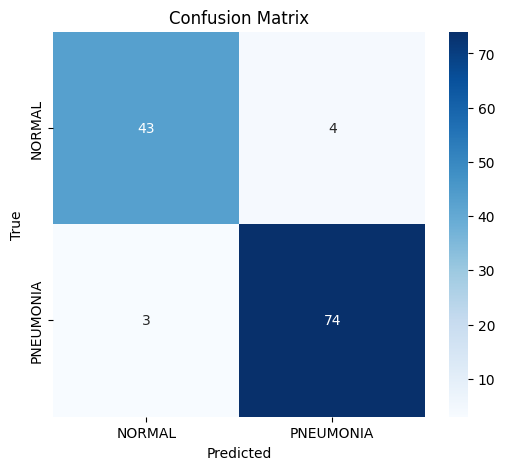

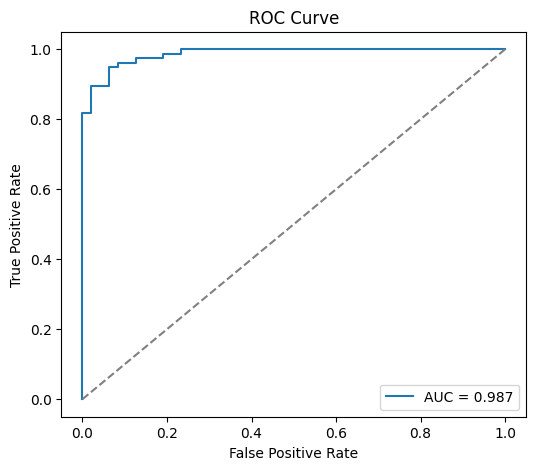

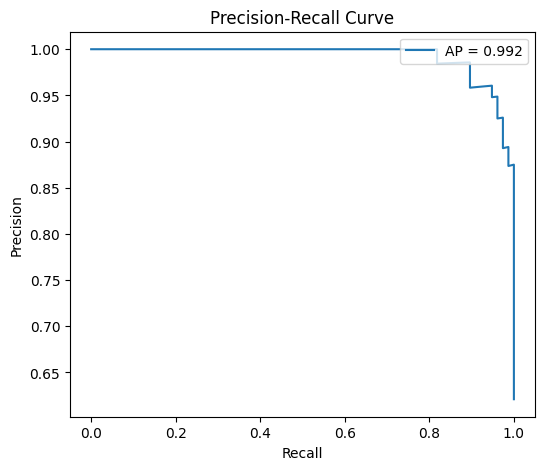

In [ ]:
# ─── Final Summary of Model Performance (adaptive) ───

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

# 1) Gather true labels and predicted probabilities
if 'val_ds' in globals():
    # Using tf.data pipeline
    y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
    probs  = model.predict(val_ds).ravel()
else:
    # Using ImageDataGenerator
    val_gen.reset()
    probs  = model.predict(val_gen,
                           steps=val_gen.samples//val_gen.batch_size + 1).ravel()
    y_true = val_gen.classes[:len(probs)]

y_pred = (probs > 0.5).astype(int)

# 2) Compute metrics
cm         = confusion_matrix(y_true, y_pred)
report     = classification_report(y_true, y_pred, target_names=['NORMAL','PNEUMONIA'])
fpr, tpr, _= roc_curve(y_true, probs)
roc_auc    = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_true, probs)
pr_auc     = average_precision_score(y_true, probs)

# 3) Print textual summary
print("=== Classification Report ===")
print(report)
print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR  AUC: {pr_auc:.3f}")

# 4) Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 5) Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 6) Plot Precision-Recall Curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {pr_auc:.3f}")
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.show()
